In [1]:
import heeps
from copy import deepcopy
from heeps.wavefront.get_array import show_wf, get_wf
from heeps.util.psf_template import psf_template
from heeps.util.lamD import get_lamD_mas
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import vip_hci

/home/oabsil/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_band_mode(case):
    band_mode = {'ELT-L' :  ('L', 'ELT'),
                 'ELT-N' :  ('N2', 'ELT'),
                 'IMG-LM' : ('L', 'IMG'),# "spider mask"
                 'APP-LM' : ('L', 'APP'),
                 'SPP-LM' : ('L', 'SPP'),
                 'RLS-LM' : ('L', 'RAVC'),
                 'CLS-LM' : ('L', 'CVC'),
                 'ULS-LM' : ('L', 'CLC'),
                 'IMG-N'  : ('N2', 'IMG'),# "spider mask"
                 'CLS-N'  : ('N2', 'CVC'),
                 'ULS-N'  : ('N2', 'CLC'),
                 'LMS'    : ('L', 'LMS'),
                 'APP-LMS': ('L', 'APP'),
                 'RLS-LMS': ('L', 'RAVC'),
                 'CLS-LMS': ('L', 'CVC'),
                 'ULS-LMS': ('L', 'CLC')}
    return band_mode[case]

def get_margins(case):
    ls_dR = {'ELT-L' :  (0, 0, 0),# no stop at all
             'ELT-N' :  (0, 0, 0),
             'IMG-LM' : (2.09, 2.09, 2.91),
             'APP-LM' : (2.09, 2.09, 2.91),# load fits file
             'SPP-LM' : (0, 0, 0), # SPP defines its own stop
             'RLS-LM' : (4.77, 4.00, 2.49),# one spider is thicker
             'CLS-LM' : (2.09, 9.00, 2.45),# one spider is thicker
             'ULS-LM' : (10.95, 4.91, 3.17),
             'IMG-N'  : (2.68, 2.68, 3.57),
             'CLS-N'  : (2.68, 9.00, 3.57),# one spider is thicker
             'ULS-N'  : (10.45, 5.11, 3.83),
             'LMS'    : (2.41, 2.41, 3.08),
             'APP-LMS': (2.41, 2.41, 3.08),# load fits file
             'RLS-LMS': (4.68, 4.00, 2.80),
             'CLS-LMS': (2.18, 9.00, 2.88),
             'ULS-LMS': (10.95, 4.91, 3.17),
             }
    return np.round(np.array(ls_dR[case])/100, 4)

def get_throughput(cases, ELT_aper_flux=None, spp_trans=0.90, lom_trans=0.92,
                   spi_width=0.54, spi_width_thin=0.31, verbose=False):
    for case in cases:
        print(f'Processing case {case}:')
        band, mode = get_band_mode(case)
        ls_dRext, ls_dRint, ls_dRspi = get_margins(case)
        f_app_amp = 'optics/app/METIS_%s.fits'%('LMS_aper' if 'LMS' in case else 'IMG_aper_rot')
        f_app_phase = 'optics/app/METIS_%s.fits'%('LMS_vAPP_final' if 'LMS' in case else 'IMG_vAPP_final_rot')
        f_spp_amp = 'optics/spp/SP_AP2_masked_rot_crop_bin.fits'
        conf = dict(band=band, mode=mode, nframes=1, add_phase=False, 
                    f_app_phase=f_app_phase, f_app_amp=f_app_amp, f_spp_amp=f_spp_amp,
                    ls_dRext=ls_dRext, ls_dRint=ls_dRint, ls_dRspi=ls_dRspi,
                    f_pupil='pupil/ELT_fullM1_nov2024.fits')
        # IMG vortex modes have 5 thinner spiders
        if case in ['RLS-LM', 'CLS-LM', 'CLS-N']:
            conf.update(
                spi_angles = [60, 120, 180, 240, 300],
                spi_width = spi_width_thin,
                AP_angles = [0],
                AP_width = spi_width,
            )
        conf = heeps.config.read_config(**conf)
        conf = heeps.config.update_config(**conf, verbose=verbose)
        wf = heeps.pupil.pupil(**conf)
        amp = get_wf(wf, 'amp', npupil=conf['npupil'])
        # ELT PSF
        ELT_psf = heeps.optics.detector(deepcopy(wf), **conf)
        _, ELT_fwhm, ELT_aper_flux = psf_template(ELT_psf)
        (ny, nx) = ELT_psf.shape
        (cx, cy) = (nx//2, ny//2)
        print('ELT: fwhm=%.2fpix, aper_flux=%.4f, (cx,cy)=(%.1f,%.1f)'%(ELT_fwhm, ELT_aper_flux, cx, cy))
        if 'ELT' in mode:
            PSF = ELT_psf
            TOTAL = 1
            mode_thruput = 1
        else: # other modes
            onaxis = True if mode in ['APP', 'SPP'] else False
            wf = heeps.optics.apodizer(wf, onaxis=onaxis, verbose=verbose, **conf)
            wf = heeps.optics.lyot_stop(wf, verbose=verbose, **conf)
            amp = get_wf(wf, 'amp', npupil=conf['npupil'])
            mode_thruput = np.sum(amp**2)
            PSF = heeps.optics.detector(wf, **conf)
            # FWHM aperture photometry
            aper_flux = vip_hci.metrics.aperture_flux(PSF, [cy], [cx], ELT_fwhm, verbose=False)[0]
            if 'APP' in mode:
                aper_flux *= conf['app_single_psf']
                mode_thruput *= conf['app_single_psf']
            # if 'APP' in mode:
            #     pupil_throughtput = np.sum(get_wf(wf, 'amp')**2)
            #     #print('pupil throughput (wrt ELT) = %.4f'%pupil_throughtput)
            #     aper_flux = ELT_aper_flux*pupil_throughtput*conf['app_strehl']*conf['app_single_psf']
            #     print('(APP Strehl = %s, single PSF = %s) aper_flux = %.4f'%(conf['app_strehl'], conf['app_single_psf'], aper_flux))    
            # if 'ELT' in mode:
            #     pass
            # printing the pure effect of PSF deformation, not taking into account any other effect (pupil mask, material, etc)
            print('This mode FWHM throughput (wrt ELT) = %.4f'%(aper_flux/ELT_aper_flux/mode_thruput))
            if 'VC' in mode:
                data = fits.getdata(conf['f_vc_trans'])
                mask_trans = np.interp(conf['lam']*1e6, data[0], data[1])
                print('VPM transmittance = %.4f'%mask_trans)
            elif 'APP' in mode:
                data = fits.getdata(conf['f_app_trans'])
                mask_trans = np.interp(conf['lam']*1e6, data[0], data[1])
                print('APP transmittance = %.4f'%mask_trans)
            elif 'SPP' in mode:
                mask_trans = spp_trans # cf. MAIT ZnSe QA -- 90% = estimation for 5mm extrapolated from 2mm data, needs update based on measurement
                print('SPP transmittance = %.4f'%mask_trans)        
            elif 'CLC' in mode:
                mask_trans = lom_trans # cf. MAIT ZnSe QA -- 92% = based on Artemis data + lab measurements
                print('LOM transmittance = %.4f'%mask_trans)        
            else:
                mask_trans = 1
            TOTAL =  aper_flux/ELT_aper_flux * mask_trans
            mode_thruput *= mask_trans

        print('Mode throughput = %.4f'%mode_thruput)
        print('Encircled energy throughput = %.4f'%TOTAL)

        if 'VC' in mode:
            oat = fits.getdata(conf['dir_input'] + 'optics/vc/oat_%s_%s.fits'%(band, mode))
            npix = 5*get_lamD_mas(**conf)/conf['pscale']
            oat5 = np.interp(npix, oat[0], oat[1])
            print('OAT @ 5 lambda/D = %.4f'%oat5)
            print('Encircled energy throughput @ 5 lambda/D = %.4f'%(TOTAL*oat5))

        # Figure
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(amp, origin='lower')
        axes[0].set_title('ls_dRext=%.2f, ls_dRint=%.2f, ls_dRspi=%.2f'%(ls_dRext*100, ls_dRint*100, ls_dRspi*100))
        axes[1].imshow(np.log10(PSF), origin='lower')
        axes[1].set_title('PSF sum = %.4f'%np.sum(PSF))
        plt.tight_layout()
        plt.show()
    return

# ELT aperture photometry

Processing case ELT-L:
ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
Mode throughput = 1.0000
Encircled energy throughput = 1.0000


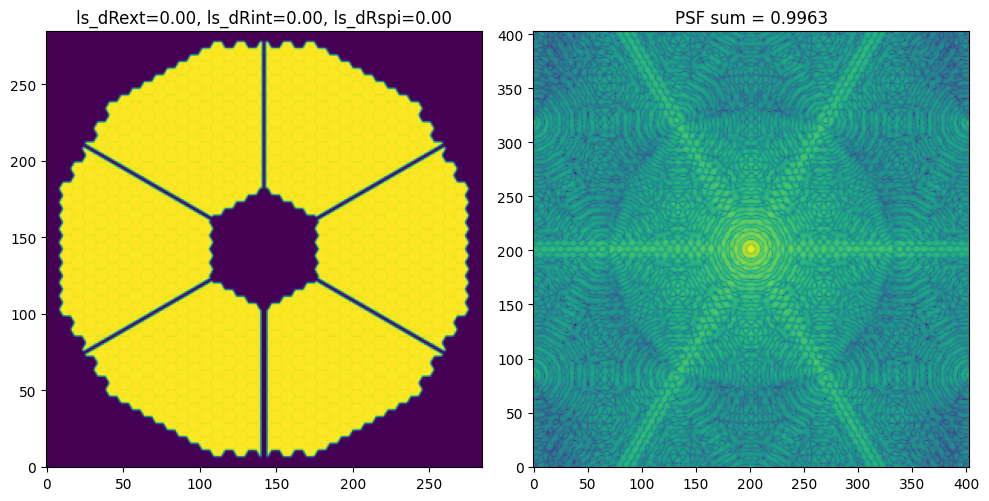

Processing case ELT-N:
ELT: fwhm=8.52pix, aper_flux=0.3739, (cx,cy)=(162.0,162.0)
Mode throughput = 1.0000
Encircled energy throughput = 1.0000


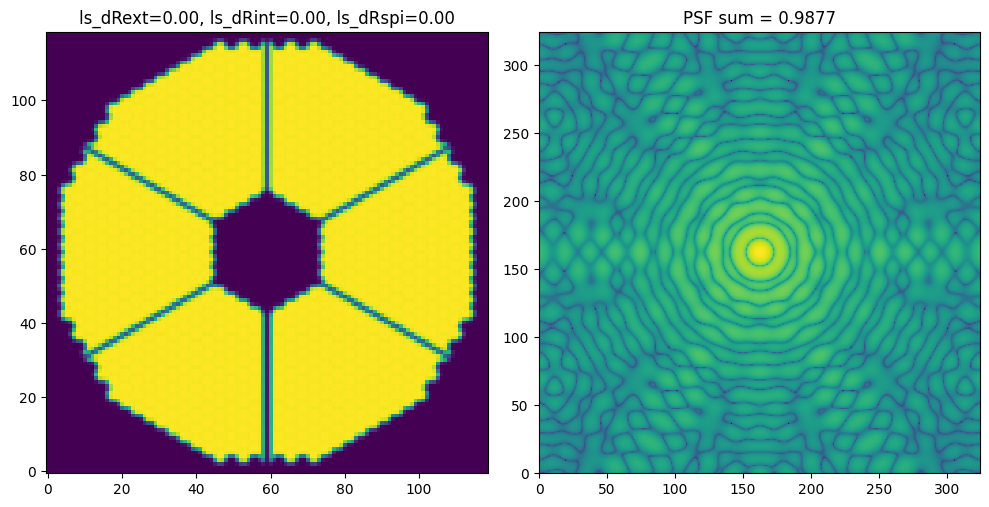

In [3]:
get_throughput(['ELT-L', 'ELT-N']);

# IMG modes
### LM bands

Processing case IMG-LM:


ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.8214
Mode throughput = 0.8157
Encircled energy throughput = 0.6700


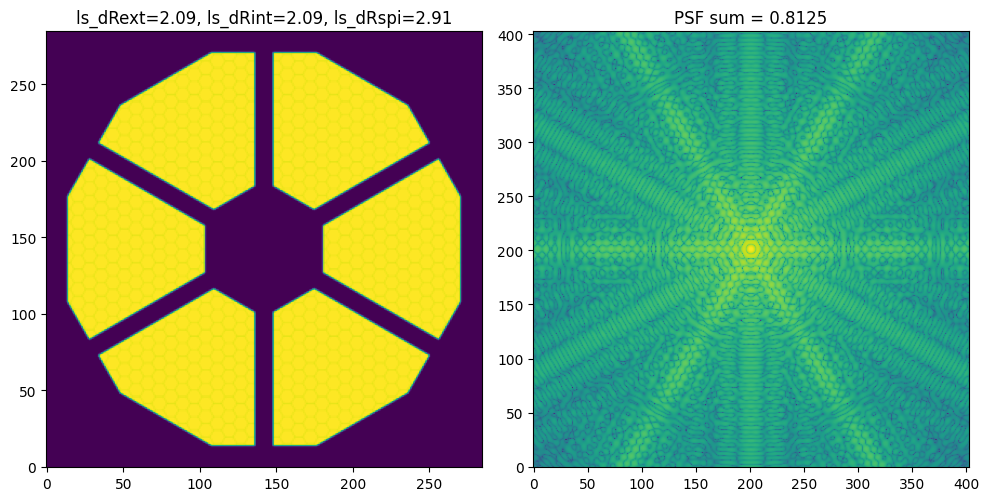

Processing case APP-LM:
ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.5443
APP transmittance = 0.7334
Mode throughput = 0.2841
Encircled energy throughput = 0.1547


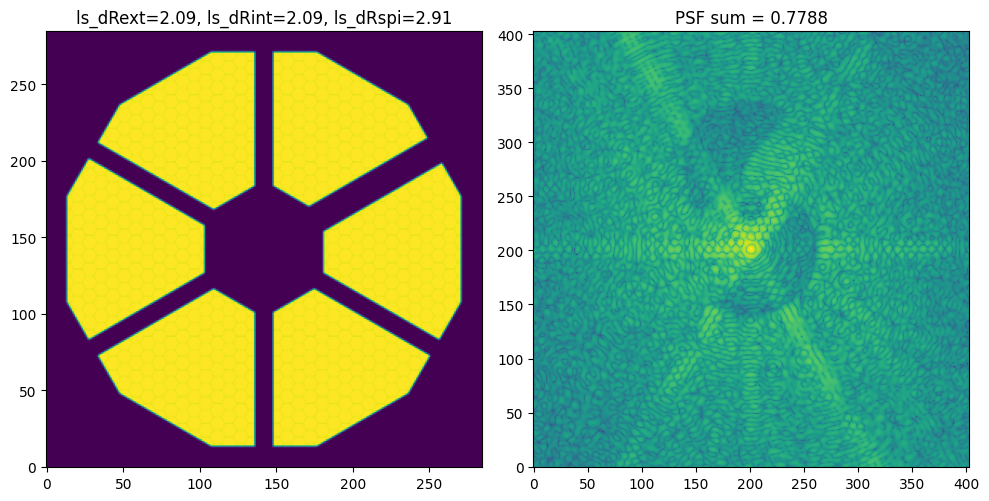

Processing case SPP-LM:
ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.4908
SPP transmittance = 0.9000
Mode throughput = 0.4047
Encircled energy throughput = 0.1986


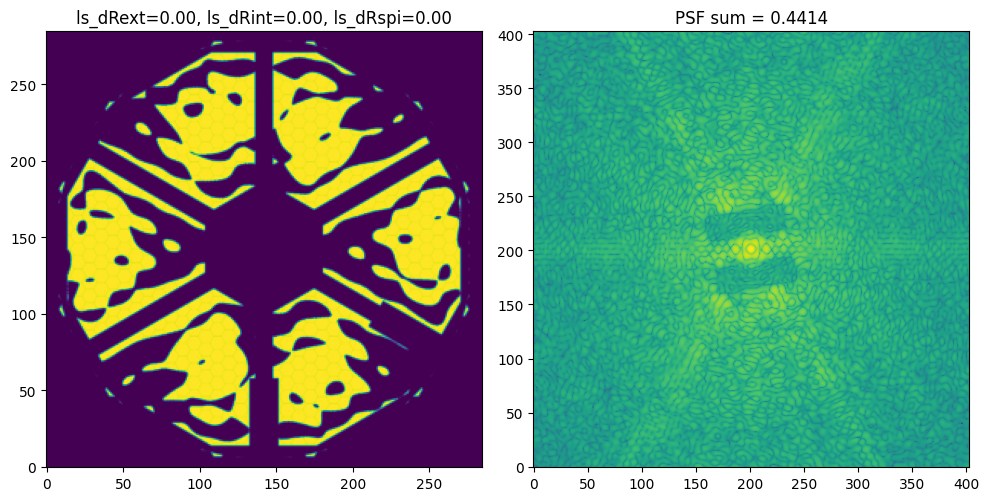

Processing case RLS-LM:
ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.5703
VPM transmittance = 0.8532
Mode throughput = 0.3133
Encircled energy throughput = 0.1787
OAT @ 5 lambda/D = 0.8829
Encircled energy throughput @ 5 lambda/D = 0.1577


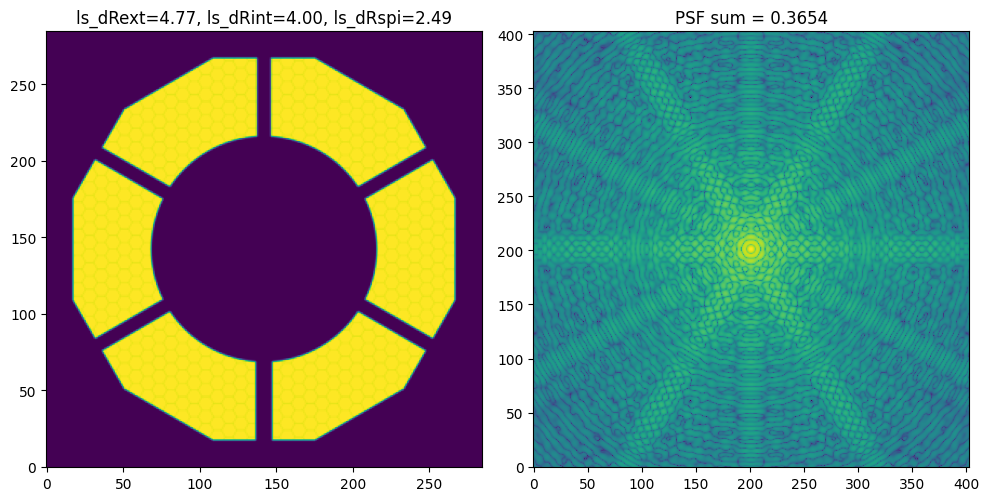

Processing case CLS-LM:
ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.7949
VPM transmittance = 0.8532
Mode throughput = 0.6815
Encircled energy throughput = 0.5417
OAT @ 5 lambda/D = 0.8188
Encircled energy throughput @ 5 lambda/D = 0.4436


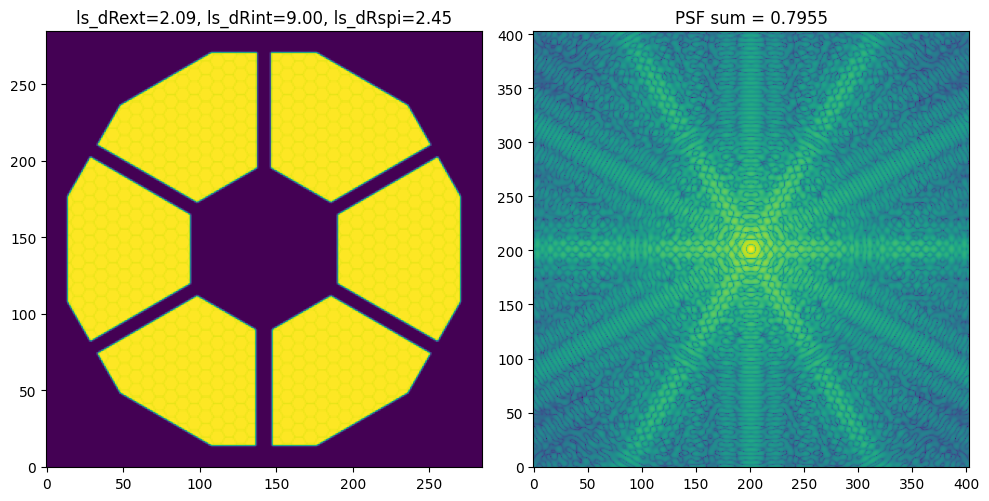

Processing case ULS-LM:
ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.6561
LOM transmittance = 0.9200
Mode throughput = 0.5741
Encircled energy throughput = 0.3767


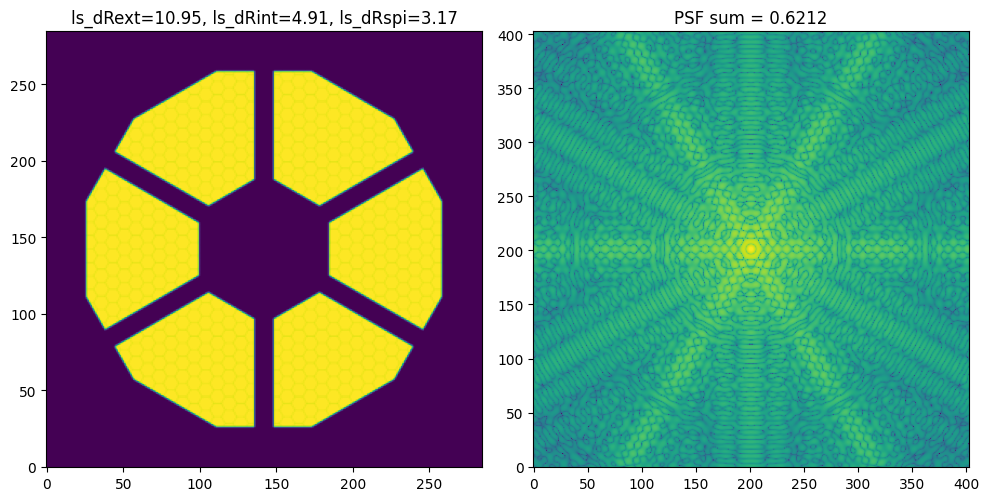

In [4]:
get_throughput(['IMG-LM','APP-LM','SPP-LM','RLS-LM','CLS-LM','ULS-LM']);

### N bands

Processing case IMG-N:


ELT: fwhm=8.52pix, aper_flux=0.3739, (cx,cy)=(162.0,162.0)
This mode FWHM throughput (wrt ELT) = 0.7909
Mode throughput = 0.7807
Encircled energy throughput = 0.6174


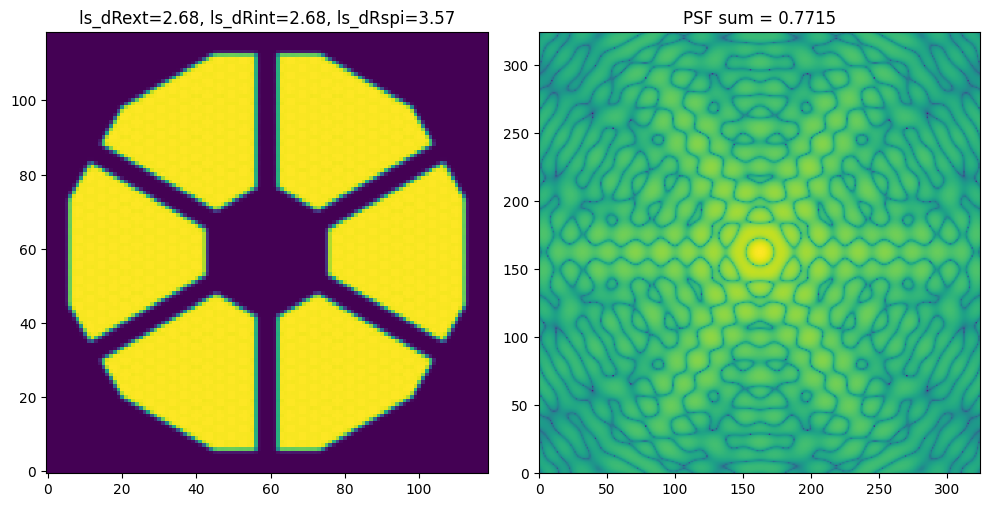

Processing case CLS-N:
ELT: fwhm=8.52pix, aper_flux=0.3739, (cx,cy)=(162.0,162.0)
This mode FWHM throughput (wrt ELT) = 0.7596
VPM transmittance = 0.9291
Mode throughput = 0.7039
Encircled energy throughput = 0.5347
OAT @ 5 lambda/D = 0.8332
Encircled energy throughput @ 5 lambda/D = 0.4455


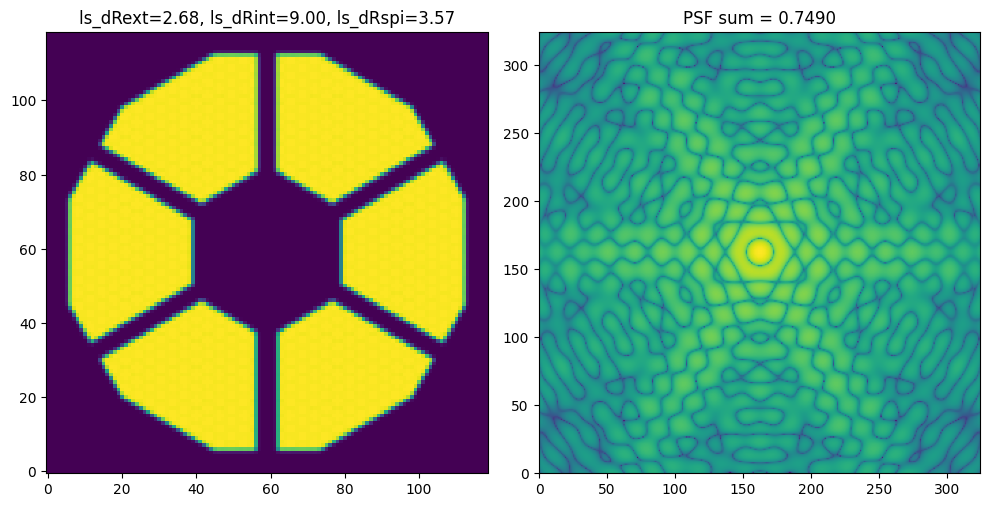

Processing case ULS-N:
ELT: fwhm=8.52pix, aper_flux=0.3739, (cx,cy)=(162.0,162.0)
This mode FWHM throughput (wrt ELT) = 0.6504
LOM transmittance = 0.9200
Mode throughput = 0.5646
Encircled energy throughput = 0.3672


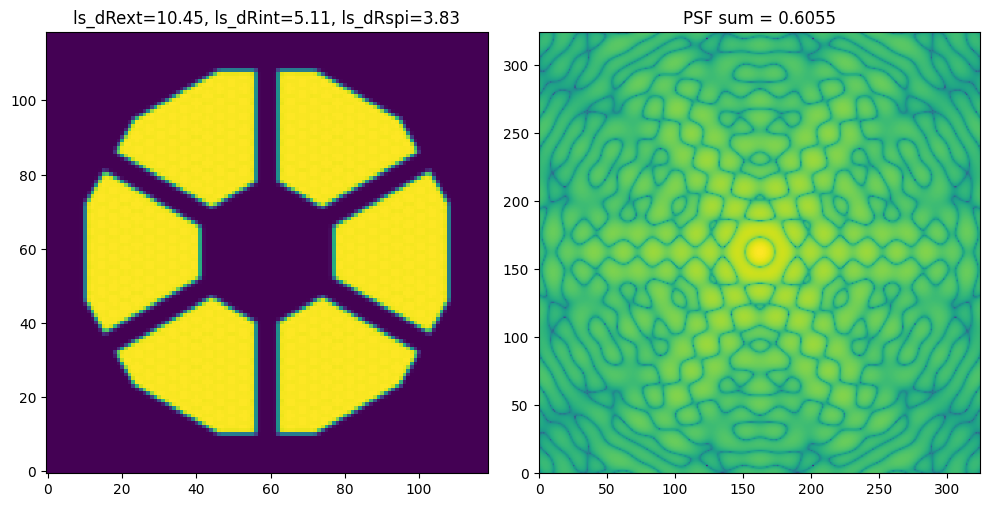

In [5]:
get_throughput(['IMG-N','CLS-N','ULS-N'])

# LMS modes

Processing case LMS:


ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.8091
Mode throughput = 0.8016
Encircled energy throughput = 0.6486


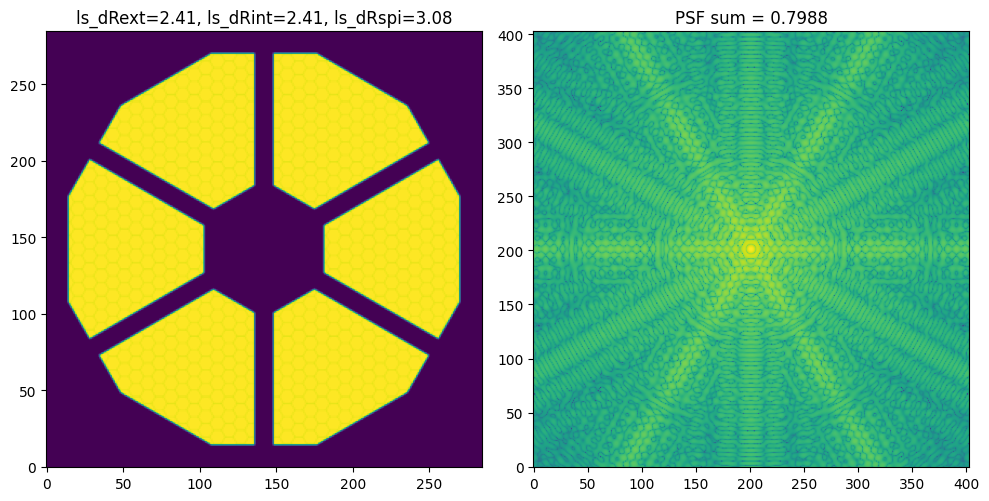

Processing case APP-LMS:
ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.5489
APP transmittance = 0.7334
Mode throughput = 0.2843
Encircled energy throughput = 0.1560


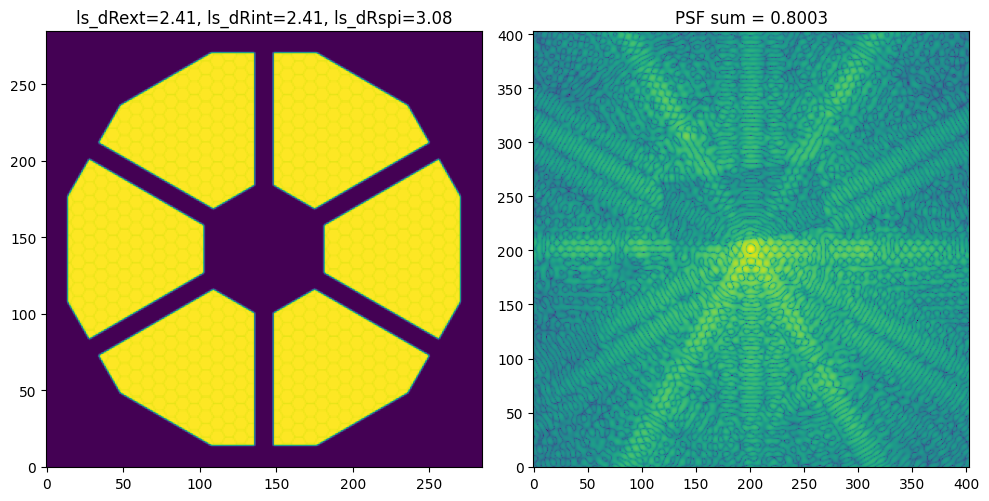

Processing case RLS-LMS:
ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.5584
VPM transmittance = 0.8532
Mode throughput = 0.3067
Encircled energy throughput = 0.1713
OAT @ 5 lambda/D = 0.8828
Encircled energy throughput @ 5 lambda/D = 0.1512


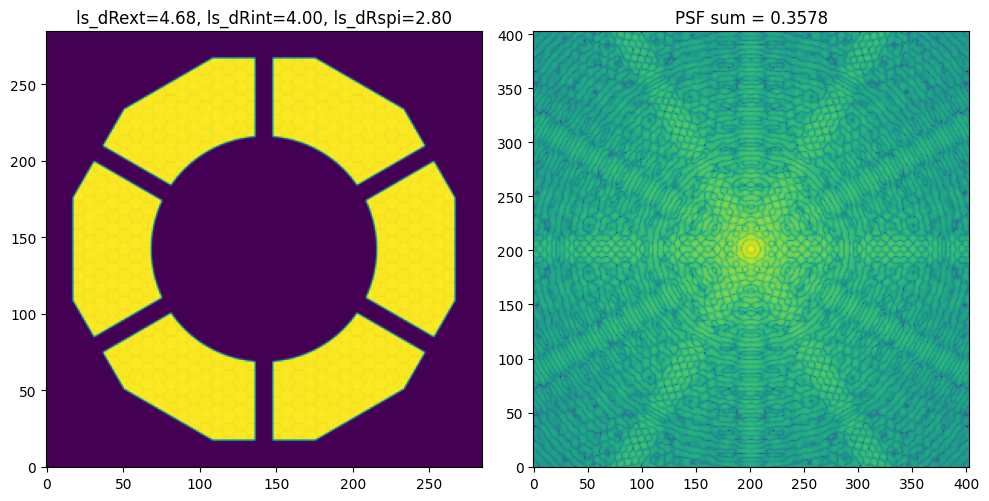

Processing case CLS-LMS:
ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.7705
VPM transmittance = 0.8532
Mode throughput = 0.6597
Encircled energy throughput = 0.5083
OAT @ 5 lambda/D = 0.8190
Encircled energy throughput @ 5 lambda/D = 0.4163


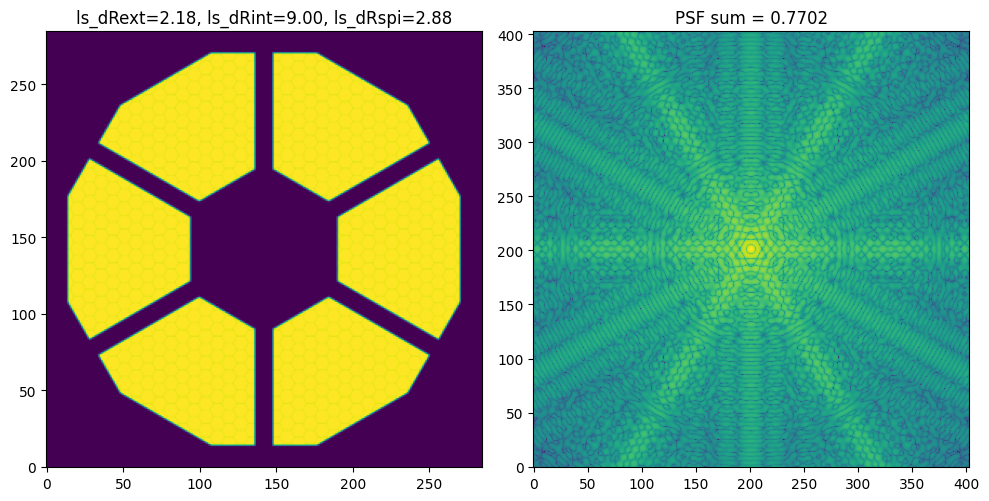

Processing case ULS-LMS:
ELT: fwhm=3.52pix, aper_flux=0.3566, (cx,cy)=(201.0,201.0)
This mode FWHM throughput (wrt ELT) = 0.6561
LOM transmittance = 0.9200
Mode throughput = 0.5741
Encircled energy throughput = 0.3767


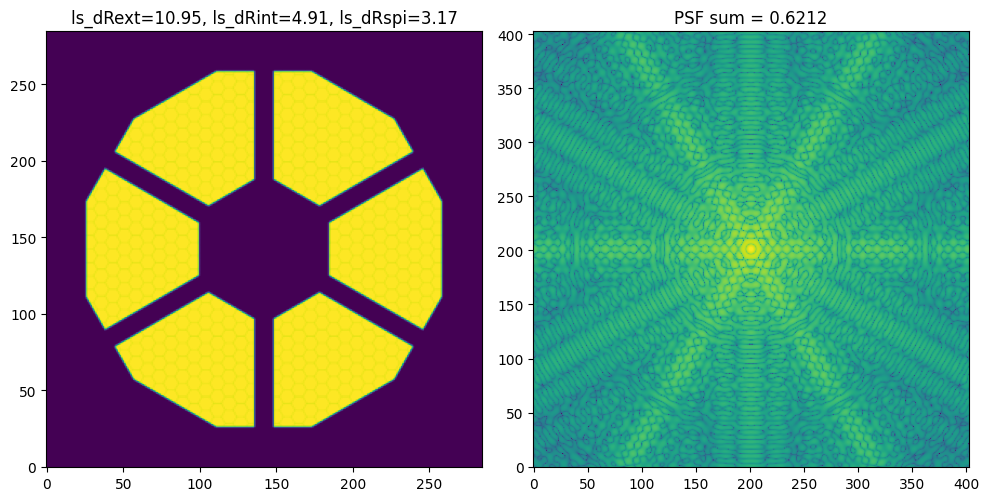

In [6]:
get_throughput(['LMS', 'APP-LMS', 'RLS-LMS', 'CLS-LMS', 'ULS-LMS']);